In [65]:
# Loading requisite libraries and establishing connection with wrds
# https://wrds-www.wharton.upenn.edu
import pandas as pd
import numpy as np
import wrds
import plotly.express as px
db = wrds.Connection(wrds_username="rajee006")

Loading library list...
Done


In [66]:
# SQL query to grab 2020 financials on net income, revenue, and employees
df = db.raw_sql(
    """
select gvkey,tic,fyear,datadate,conm,revt,ni,emp,prcc_f, ceq,
oancf,at,dltt,act,lct,csho,cogs
from compa.funda where datadate between '01/01/1976' and '12/31/2021'
and datafmt in ('STD') and consol in ('C') and popsrc in ('D') and indfmt in 
('INDL') and curcd in ('USD')
"""
)


In [67]:
# Generate variables
df["mcap"] = df["prcc_f"] * df["csho"]
df["btm"] = df["ceq"] / df["mcap"]

In [68]:
# Profitability Criteria

# Net income
df["f1"] = (df["ni"] > 0).astype(int)

# Operating cash flows
df["f2"] = (df["oancf"] > 0).astype(int)

# ROA
df.sort_values(by=["gvkey", "datadate"], ascending=True, inplace=True)
df["roa"] = df["ni"] / df["at"]
df["lag_roa"] = df.groupby(["gvkey"])["roa"].shift(1)
df["f3"] = (df["roa"] > df["lag_roa"]).astype(int)

# Quality of earnings
df["f4"] = (df["oancf"] > df["ni"]).astype(int)

In [69]:
# Leverage, Liquidity, and Source of Funds Criteria 

# Long term debt vs assets
df["ltd"] = df["dltt"] / df["at"]
df["lag_ltd"] = df.groupby(["gvkey"])["dltt"].shift(1)
df["f5"] = (df["ltd"] > df["lag_ltd"]).astype(int)
# Current ratio
df["cr"] = df["act"] / df["lct"]
df["lag_cr"] = df.groupby(["gvkey"])["cr"].shift(1)
df["f6"] = (df["cr"] > df["lag_cr"]).astype(int)
# Shares outstanding
df["lag_csho"] = df.groupby(["gvkey"])["csho"].shift(1)
df["f7"] = (df["csho"] <= df["lag_csho"]).astype(int)


In [70]:
# Operating Efficiency Criteria 

# Gross margin
df["gm"] = (df["revt"] - df["cogs"]) / df["revt"]
df["lag_gm"] = df.groupby(["gvkey"])["gm"].shift(1)
df["f8"] = (df["gm"] > df["lag_gm"]).astype(int)
# Asset Turnover
df["asset_turnover"] = df["revt"] / df["at"]
df["lag_asset_turnover"] = df.groupby(["gvkey"])["asset_turnover"].shift(1)
df["f9"] = (df["asset_turnover"] > df["lag_asset_turnover"]).astype(int)


In [71]:
# QC Step
# Checking presence of specific stocks as a QC
df[df['tic']=='AAPL'].head(10)

,gvkey,tic,fyear,datadate,conm,revt,ni,emp,prcc_f,ceq,...,lag_cr,f6,lag_csho,f7,gm,lag_gm,f8,asset_turnover,lag_asset_turnover,f9
9468,001690,AAPL,1980.0,1980-09-30,APPLE INC,117.126,11.698,1.015,NaN,25.949,...,NaN,0,NaN,0,0.436914,NaN,0,1.792288,NaN,0
9469,001690,AAPL,1981.0,1981-09-30,APPLE INC,334.783,39.420,2.456,15.249996,177.387,...,1.432133,1,48.397,0,0.486918,0.436914,1,1.313709,1.792288,0
9448,001690,AAPL,1982.0,1982-09-30,APPLE INC,583.061,61.306,3.391,18.249985,257.092,...,3.231417,1,55.309,0,0.534448,0.486918,1,1.629632,1.313709,1
9463,001690,AAPL,1983.0,1983-09-30,APPLE INC,982.769,76.714,4.645,23.125000,377.901,...,3.697409,0,57.123,0,0.508201,0.534448,0,1.765731,1.629632,1
9466,001690,AAPL,1984.0,1984-09-30,APPLE INC,1515.876,64.055,5.382,25.125000,464.565,...,3.641646,0,59.198,0,0.445454,0.508201,0,1.921784,1.765731,1
9470,001690,AAPL,1985.0,1985-09-30,APPLE INC,1918.280,61.223,4.300,15.750000,550.487,...,2.694334,1,60.535,0,0.439069,0.445454,0,2.049057,1.921784,1
9471,001690,AAPL,1986.0,1986-09-30,APPLE INC,1901.897,153.963,5.600,33.500000,694.087,...,2.782652,1,61.850,0,0.558316,0.439069,1,1.639385,2.049057,0
9472,001690,AAPL,1987.0,1987-09-30,APPLE INC,2661.068,217.496,7.228,56.500000,836.488,...,3.168411,0,62.628,0,0.539394,0.558316,0,1.800536,1.639385,1
9473,001690,AAPL,1988.0,1988-09-30,APPLE INC,4071.373,400.258,10.800,43.250000,1003.425,...,2.731325,0,126.088,1,0.530084,0.539394,0,1.955430,1.800536,1
9474,001690,AAPL,1989.0,1989-09-30,APPLE INC,5284.013,454.033,14.517,44.500000,1485.746,...,2.155736,1,122.768,0,0.513623,0.530084,0,1.925732,1.955430,0


In [72]:
# QC Step
# Checking if all scores are in
df.columns

Index(['gvkey', 'tic', 'fyear', 'datadate', 'conm', 'revt', 'ni', 'emp',
       'prcc_f', 'ceq', 'oancf', 'at', 'dltt', 'act', 'lct', 'csho', 'cogs',
       'mcap', 'btm', 'f1', 'f2', 'roa', 'lag_roa', 'f3', 'f4', 'ltd',
       'lag_ltd', 'f5', 'cr', 'lag_cr', 'f6', 'lag_csho', 'f7', 'gm', 'lag_gm',
       'f8', 'asset_turnover', 'lag_asset_turnover', 'f9'],
      dtype='object')

In [73]:
# Assigning the piotroski score based on all characteristics
df["fscore"] = df["f1"] + df["f2"] + df["f3"] + df["f4"] + df["f5"] + df["f6"] + df["f7"] + df["f8"] + df["f9"]

In [74]:
# Sample select out observations with missing input variables which will delete observations that are erroneously coded as zero
df = df.dropna(
    subset=[
        "ni",
        "revt",
        "ceq",
        "prcc_f",
        "csho",
        "oancf",
        "dltt",
        "at",
        "act",
        "lct",
        "cogs",
        "lag_gm",
        "gm",
        "lag_csho",
        "lag_asset_turnover",
        "asset_turnover",
        "ltd",
        "lag_roa",
    ]
)

In [75]:
#Check missing values in any columns?

# Ensuring that all the rows have all the scores required for the piotroski score
df.isnull().any()

gvkey                 False
tic                   False
fyear                 False
datadate              False
conm                  False
revt                  False
ni                    False
emp                    True
prcc_f                False
ceq                   False
oancf                 False
at                    False
dltt                  False
act                   False
lct                   False
csho                  False
cogs                  False
mcap                  False
btm                   False
f1                    False
f2                    False
roa                   False
lag_roa               False
f3                    False
f4                    False
ltd                   False
lag_ltd                True
f5                    False
cr                     True
lag_cr                 True
f6                    False
lag_csho              False
f7                    False
gm                    False
lag_gm                False
f8                  

<AxesSubplot:>

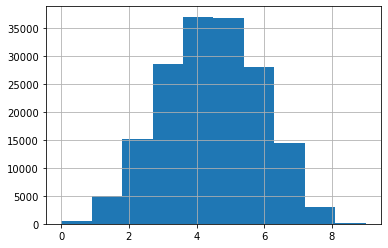

In [76]:
# Histogram of F-Score

# Checking the histogram to check if it is a normal distribution which is expected
df["fscore"].hist(bins=10)

In [77]:
# Examples of high and low BTM - Book to Market Ratio
df["btm"].describe()

count    1.684350e+05
mean              NaN
std               NaN
min              -inf
25%      1.999892e-01
50%      4.351996e-01
75%      7.823087e-01
max               inf
Name: btm, dtype: float64

In [78]:
# High BTM examples
# High BTM is approximately 0.80
RandomHighBTM = df[df["btm"] >= 0.80].sample(n=10)
RandomHighBTM[["fyear", "conm"]]

,fyear,conm
187830,1993.0,ANANGEL AMER SHIPHLDGS -ADR
156758,2012.0,PRO-DEX INC/CO
294859,2019.0,LIGHTPATH TECHNOLOGIES INC
406816,2017.0,ALTERITY THERAPEUTICS LTD
231000,1999.0,WORLD ACCESS INC
124592,2010.0,STARRETT (L.S.) CO -CL A
291719,2016.0,WESTELL TECH INC -CL A
315277,2002.0,INHIBITOR THERAPEUTICS INC
313040,2000.0,CTB INTERNATIONAL CORP
59374,2007.0,GRUBB & ELLIS CO


In [79]:
# Low BTM Examples
# Low BTM is approximately 0.20
RandomLowBTM = df[df["btm"] <= 0.20].sample(n=10)
RandomLowBTM[["fyear", "conm"]]

,fyear,conm
343738,2002.0,ON SEMICONDUCTOR CORP
301270,2012.0,STRATEGIC EDUCATION INC
133608,1996.0,TRANSACT INTL INC
204789,2020.0,AZUL SA
351080,2007.0,ROCKWELL COLLINS
245498,1999.0,WILSHIRE TECHNOLOGIES INC
275236,2000.0,MICREL INC
333533,2000.0,TW TELECOM INC
270109,1994.0,THERMOLASE CORP
244912,2020.0,ACLARIS THERAPEUTICS INC


In [80]:
# Examples of high F-scores
RandomHighFScore = df[df["fscore"] >= 8].sample(n=10)
RandomHighFScore[["fyear", "conm"]]

,fyear,conm
169379,1991.0,TECHKNITS INC
211471,1996.0,UMC INC
83871,2008.0,MCDONALD'S CORP
25120,1995.0,CENTRAL VERMONT PUB SERV
142115,1997.0,WALKER (B.B.) CO
7400,2005.0,AMERICAN SCIENCE ENGINEERING
179672,1993.0,RESURGENS COMMUNICATIONS GP
60601,1996.0,HANDLEMAN CO
220151,1998.0,INTEGRAL SYSTEMS INC
290808,2000.0,NEW HORIZON KIDS QUEST INC


In [81]:
# Examples of low F-Scores
RandomLowFScore = df[df["fscore"] <= 1].sample(n=10)
RandomLowFScore[["fyear", "conm"]]

,fyear,conm
260145,1995.0,FRIEDMANS INC -CL A
338307,2005.0,A21 GROUP INC
407195,2007.0,MNC MEDIA INVESTMENT LTD
220555,1999.0,ENVIRONMENTAL ENERGY SERVICE
27048,1993.0,CHIEF CONSOLIDATED MINING CO
45507,1996.0,EMULEX CORP
273016,1997.0,SUGEN INC
156244,1993.0,FLUOR DANIEL/GTI INC
176614,2001.0,OMAGINE INC
310296,2006.0,SAREPTA THERAPEUTICS INC


In [82]:
# Examples of high F-score AND high BTM
RandomHighFScoreBTM = df[(df["fscore"] >= 8) & (df["btm"] >= 0.80)].sample(n=10)
RandomHighFScoreBTM[["fyear", "conm"]]

,fyear,conm
258711,1997.0,CAPTIVA SOFTWARE CORP
319714,2007.0,GSV INC
375215,2011.0,NYSE EURONEXT
7703,1992.0,AMERICAN TECHNICAL CERAMICS
253289,1995.0,MARTIN COLOR-FI INC
97602,1996.0,OAKRIDGE ENERGY INC
101489,1991.0,PAR TECHNOLOGY CORP
14830,2000.0,EARTHSTONE ENERGY INC -OLD
47589,1994.0,EXOLON ESK CO
128278,2015.0,TSR INC


In [83]:
# Examples of low F-score AND low BTM
RandomLowFScoreBTM = df[(df["fscore"] <= 1) & (df["btm"] >= 0.80)].sample(n=10)
RandomLowFScoreBTM[["fyear", "conm"]]

,fyear,conm
117755,1998.0,SCOTT'S LIQUID GOLD
185147,1997.0,3D SYSTEMS CORP
407776,2008.0,DESIGN WITHIN REACH INC
405229,1998.0,ATLAS PEARLS LTD
239047,2000.0,METRICOM INC
615,2002.0,AMERICAN AIRLINES GROUP INC
398837,2013.0,FERONIA INC
193573,1998.0,BEI MEDICAL SYSTEMS CO INC
255759,1998.0,BELL MICROPRODUCTS INC
176550,2004.0,WEGENER CORP


In [84]:
# Examples of high F-score AND high BTM AND FYEAR=2019
RandomHighFScoreBTM2019 = df[(df["fscore"] >= 8) & (df["btm"] >= 0.80) & 
(df["fyear"] == 2019)]
RandomHighFScoreBTM2019[["fyear", "conm"]]

,fyear,conm
86791,2019.0,MICROPAC INDUSTRIES INC
279986,2019.0,QUDIAN INC
308852,2019.0,COPEL-CIA PARANAENSE ENERGIA
320637,2019.0,VOLKSWAGEN AG
336698,2019.0,ALAMOS GOLD INC
388482,2019.0,TEEKAY TANKERS LTD
390908,2019.0,LUCARA DIAMOND CORP
393590,2019.0,GLOBAL CORD BLOOD CORP
406654,2019.0,GAZIT GLOBE
408111,2019.0,EURONAV


In [85]:
# Examples of low F-score AND low BTM  AND FYEAR=2019
RandomLowFScoreBTM2019 = df[(df["fscore"] <= 1) & (df["btm"] >= 0.80) & 
(df["fyear"] == 2019)].sample(n=10)
RandomLowFScoreBTM2019[["fyear", "conm"]]

,fyear,conm
280604,2019.0,FARMMI INC
298993,2019.0,BOS BETTER ONLINE SOLUTIONS
119151,2019.0,SERVOTRONICS INC
55267,2019.0,GEE GROUP INC
224547,2019.0,BARNES & NOBLE EDUCATION INC
206736,2019.0,APPLIED OPTOELECTRONICS INC
406818,2019.0,ALTERITY THERAPEUTICS LTD
205529,2019.0,DOCUMENT SECURITY SYS INC
211430,2019.0,CASTLIGHT HEALTH INC
252951,2019.0,FOSSIL GROUP INC


In [89]:
final_scores = df[["fyear", "tic","conm","f1","f2","f3","f4","f5","f6","f7","f8","f9","fscore"]]
final_scores.head(10)

,fyear,tic,conm,f1,f2,f3,f4,f5,f6,f7,f8,f9,fscore
18,1987.0,ANTQ,A.A. IMPORTING CO INC,1,0,0,0,0,1,1,0,0,3
19,1988.0,ANTQ,A.A. IMPORTING CO INC,0,0,0,1,0,0,1,0,0,2
20,1989.0,ANTQ,A.A. IMPORTING CO INC,0,0,1,1,0,0,1,1,0,4
36,1988.0,AIR,AAR CORP,1,1,0,0,0,0,0,1,0,3
37,1989.0,AIR,AAR CORP,1,1,0,0,0,1,0,0,1,4
38,1990.0,AIR,AAR CORP,1,1,0,1,0,1,1,0,1,6
39,1991.0,AIR,AAR CORP,1,1,0,0,0,0,0,1,0,3
40,1992.0,AIR,AAR CORP,1,1,0,1,0,1,0,0,0,4
41,1993.0,AIR,AAR CORP,1,1,1,0,0,1,0,0,0,4
42,1994.0,AIR,AAR CORP,1,1,1,1,0,0,0,1,1,6
